### Setup

In [3]:
# ----------------------- #
# NOTEBOOK MPI EXPERIMENT #
# AUTHOR: XIAOYANG SONG   #
# ----------------------- #
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from tabulate import tabulate
sys.path.append('../../')
from MPI.mpi import *

### Toy Example

In [2]:
from transformers import AutoTokenizer, RobertaModel
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
ic(outputs.last_hidden_state.shape)

ic| outputs.last_hidden_state.shape: torch.Size([1, 8, 768])


torch.Size([1, 8, 768])

In [25]:
from transformers import AutoTokenizer, RobertaForCausalLM, AutoConfig
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# config = AutoConfig.from_pretrained("roberta-base")
# config.is_decoder = False
# config.is_decoder=True

# model = BertLMHeadModel.from_pretrained("bert-base-uncased")
model = RobertaForCausalLM.from_pretrained("roberta-base")

inputs = tokenizer("Hello Hello World.\nAnswer: (A). Very Inaccurate", return_tensors="pt")
choice = tokenizer("(A). Very Inaccurate", return_tensors='pt', padding=True)
ic(len(choice.input_ids[0,1:-1]))
ic(tokenizer.decode(choice.input_ids[0]))
ic(tokenizer.decode(choice.input_ids[0][1:-1]))
# inputs = tokenizer("Hello, my dog is cute, I love dog", return_tensors="pt")
ic(inputs)
ic(tokenizer.decode(inputs.input_ids[0][-8:-1]))
outputs = model(**inputs)

prediction_logits = outputs.logits

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
ic| len(choice.input_ids[0,1:-1]): 7
ic| tokenizer.decode(choice.input_ids[0]): '<s>(A). Very Inaccurate</s>'
ic| tokenizer.decode(choice.input_ids[0][1:-1]): '(A). Very Inaccurate'
ic| inputs: {'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
             'input_ids': tensor([[    0, 31414, 20920,   623,     4, 50118, 33683,    35,    36,   250,
                       322, 12178,    96,  7904, 23412,     2]])}
ic| tokenizer.decode(inputs.input_ids[0][-8:-1]): ' (A). Very Inaccurate'


In [26]:
ic(prediction_logits.squeeze().shape)
ic(inputs.input_ids[0].shape)
prob = torch.softmax(prediction_logits.squeeze(), dim=-1)
ic(prob.shape)
masked_prob = prob[np.arange(inputs.input_ids[0].shape[0]), inputs.input_ids[0]]
ic(masked_prob.shape)
ic(masked_prob)
idx = torch.max(prob, dim=-1)[1]
ic(tokenizer.decode(idx))

ic| prediction_logits.squeeze().shape: torch.Size([16, 50265])
ic| inputs.input_ids[0].shape: torch.Size([16])
ic| prob.shape: torch.Size([16, 50265])
ic| masked_prob.shape: torch.Size([16])
ic| masked_prob: tensor([1.0000e+00, 9.9987e-01, 9.9966e-01, 9.9993e-01, 7.9664e-02, 3.7465e-12,
                         9.9995e-01, 1.0000e+00, 9.9998e-01, 9.9992e-01, 9.9142e-01, 9.9996e-01,
                         9.9976e-01, 9.9999e-01, 1.0000e+00, 9.2005e-01],
                        grad_fn=<IndexBackward0>)
ic| tokenizer.decode(idx): '<s>Hello Hello World</s></s>Answer: (A). Very Inaccurate</s>'


'<s>Hello Hello World</s></s>Answer: (A). Very Inaccurate</s>'

ic| eg.shape: torch.Size([50265])
ic| tokenizer.decode([idx]): 'Hello'


'Hello'

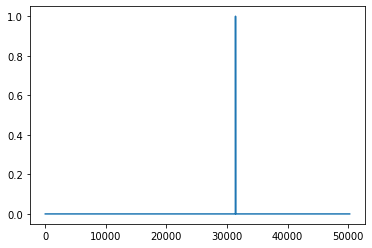

In [30]:
eg = prob[1]
ic(eg.shape)
plt.plot(np.arange(len(eg)), eg.detach().cpu())
idx = torch.argmax(eg)
ic(tokenizer.decode([idx]))

### GPT

In [32]:
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
from icecream import ic
import torch

In [46]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
inputs = tokenizer("Hello Hello World.\nAnswer: (A). Very Inaccurate", return_tensors="pt")
choice = tokenizer("(A). Very Inaccurate", return_tensors='pt')
ic(len(choice.input_ids[0,:]))
ic(tokenizer.decode(choice.input_ids[0]))
ic(tokenizer.decode(choice.input_ids[0]))
# inputs = tokenizer("Hello, my dog is cute, I love dog", return_tensors="pt")
ic(inputs)
ic(tokenizer.decode(inputs.input_ids[0][-7:]))
outputs = model(**inputs, labels=inputs.input_ids)

prediction_logits = outputs.logits
ic(prediction_logits.shape)

ic| len(choice.input_ids[0,:]): 7
ic| tokenizer.decode(choice.input_ids[0]): '(A). Very Inaccurate'
ic| tokenizer.decode(choice.input_ids[0]): '(A). Very Inaccurate'
ic| inputs: {'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
             'input_ids': tensor([[15496, 18435,  2159,    13,   198, 33706,    25,   357,    32,   737,
                      9576,   554,  4134, 15537]])}
ic| tokenizer.decode(inputs.input_ids[0][-7:]): ' (A). Very Inaccurate'
ic| prediction_logits.shape: torch.Size([1, 14, 50257])


torch.Size([1, 14, 50257])

In [47]:
probs = torch.softmax(prediction_logits, dim=-1)
ic(probs.shape)

ic| probs.shape: torch.Size([1, 14, 50257])


torch.Size([1, 14, 50257])

ic| eg.shape: torch.Size([50257])


Hello Hello World.
Answer: (A). Very Inaccurate


ic| idx: tensor(11)
ic| tokenizer.decode([idx]): ','


','

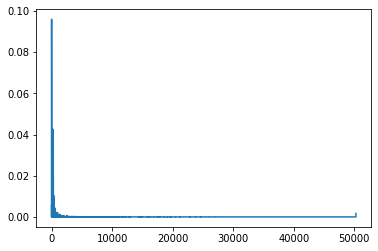

In [49]:
from matplotlib import pyplot as plt
print("Hello Hello World.\nAnswer: (A). Very Inaccurate")
eg = probs[0][0]
ic(eg.shape)
plt.plot(np.arange(len(eg)), eg.detach().cpu())
idx = torch.argmax(eg)
ic(idx)
ic(tokenizer.decode([idx]))

In [61]:
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits
ic(-loss)
ic(logits.shape)

ic| -loss: tensor(-3.9902, grad_fn=<NegBackward0>)
ic| logits.shape: torch.Size([1, 6, 50257])


torch.Size([1, 6, 50257])

In [67]:
ic(logits.shape)
idxs = torch.argmax(logits.squeeze(), dim=-1)
probs = torch.softmax(logits.squeeze(), dim=-1)[np.arange(6), inputs.input_ids[0]]
ic(probs.shape)
ic(torch.sum(torch.log(probs)))
ic(idxs)
print(tokenizer.decode(idxs))
print(tokenizer.decode(inputs.input_ids[0]))

ic| logits.shape: torch.Size([1, 6, 50257])
ic| probs.shape: torch.Size([6])
ic| torch.sum(torch.log(probs)): tensor(-53.3722, grad_fn=<SumBackward0>)
ic| idxs: tensor([  11,  314, 1438,  318,  257,   13])


, I name is a.
Hello, my dog is cute
